<a href="https://colab.research.google.com/github/omaima-9/NLP/blob/main/seg_Detect_AraBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Install the requirements and upload the files using the panel on the left.

In [1]:
!pip install farasapy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install bert-for-tf2
!pip install pyarabic
!git clone https://github.com/aub-mind/arabert
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 169 kB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30534 sha256=0ebb3413149701dbde99027adc72f741c138db29d6dab63fe289fdb75ed1da16
  Stored in directory: /root/.cache/pip/wheels/47/b6/e5/8c76ec779f54bc5c2f1b57d2200bb9c77616da83873e8acb53
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19472 sha256=793075f20486a022cd591d2f6b76e3885f1b8a70b91654c95333106dea1d8315
  Stored in directory: /root/.cache/pip/wheels/0e/fc/d2/a44fff33af0f233d7def6e7de413006d57c10e10ad736fe8f5
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7911 sha256=22b95e19fc161d97d3a43b99f538047762d349f8b6d7b818604c785980c5acee
  Stored in directory: /root/.cache/pip/wheels/e1/11/67/33cc51bbee127cb8fb2ba549cd29109b2f22da43ddf9969716
Successfully built bert-for-tf2 params-flow p

In [3]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers
import bert
from transformers import AutoTokenizer, AutoModel

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Load Data

The simpletransformers assumes two columns: text then label. Easy enough given our data.

In [4]:
# from simpletransformers.classification import ClassificationModel # Ignore wandb warning
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
import logging

import math
import re
import random

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from arabert.preprocess import ArabertPreprocessor



In [5]:
# Load train
df = pd.read_csv('LabeledDataset.csv')
df.head(10)


,commentText,Label,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Label.1
0,شمس مثقفة و جميلة وايد ... و احلام ههههععع ما ...,P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P
1,احلام اني حبيتها اكثر لان انظلمت كثير من النا...,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,كبرلفك والله دايضحكون عليج,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
3,والله كلامه صحيح عن شمس,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
4,ذكرى ما نسيناك وما حد بينسينا صوتك الجميل وطيب...,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
5,الله يرحمك اسمعو صوتها وراح تتئكدون انتي النكر...,P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P
6,اسمعي هاذا انت والصدفه ووش إخباري واحذرك وفرصه...,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
7,حتى الليبي اتقنته,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
8,غنت لجميع الدوول العربيه,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
9,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


In [6]:
df=df[['commentText','Label']]

In [16]:
# df=df.drop([ 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4',
#        'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
#        'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13',
#        'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Label.1'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15050 entries, 0 to 15049
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   commentText  11268 non-null  object
 1   Label        15050 non-null  object
dtypes: object(2)
memory usage: 235.3+ KB


In [ ]:
model_name = "aubmindlab/bert-base-arabertv2"
arabert_prep = ArabertPreprocessor( model_name=model_name,
                                    remove_html_markup = False,
                                    replace_urls_emails_mentions = False,
                                    strip_tashkeel = True,
                                    strip_tatweel = True,
                                    insert_white_spaces = False,
                                    remove_non_digit_repetition = False,
                                    replace_slash_with_dash = None,
                                    map_hindi_numbers_to_arabic = True,
                                    apply_farasa_segmentation = None)
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0010FFFF"  # wider range
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


100%|██████████| 241M/241M [00:15<00:00, 15.5MiB/s]


[2022-11-26 20:42:52,279 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [ ]:
def Pre_processing(comment):

  pat1 = '@[^ ]+' # Remove mentions
  pat2 = '#'      #
  pat3 = '[0-9]'  #remove Number
  pat4 = '[A-Za-z]' #remove english charctares
  combined_pat = '|'.join((pat1, pat2, pat3, pat4))
  comment = re.sub(combined_pat, '', comment)
  comment = re.sub('[ى]', 'ي', comment)
  comment = re.sub('[إأٱآا]', 'ا', comment)
  comment = re.sub('[ؤئ]', 'ء', comment)
  comment = re.sub('[ة]', 'ه', comment)
  comment = re.sub('[\n]', ' ', comment)
  comment = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), '', comment)  # remove punctuation
  comment=re.sub(r'(.)\1+', r'\1', comment) # remove repeated char like هههه  

  comment=remove_emoji(comment)

  comment=arabert_prep.preprocess(comment)

  return comment

In [ ]:
clean_df=df.copy()
for i in range(len(clean_df)):
  try:
    commentText=df['commentText'][i]
    commentText=Pre_processing(commentText)
    clean_df['commentText'][i]=commentText
    # if i%1000==0:
    #   print(i)
  except:
    print(commentText)


# import re
# cleanedCommentText = []

# for comment in df.commentText:
#     cleanedCommentText.append(Pre_processing(str(comment)))

# df['cleanedCommentText'] = cleanedCommentText

In [ ]:
clean_df['commentText']

0            شمس مثقف +ه و جميل +ه وايد و أحلام هع ما أقول
1        أحلام +ان +ي حبي +ت +ها أكثر لان انظلم +ت كثير...
2                              كبرلفك و+ اله دايضحكون عليج
3                               و+ اله كلام +ه صحيح عن شمس
4        ذكرى ما نسي +نا +ك و+ ما حد ب+ ينسي +نا صوت +ك...
                               ...                        
15045                        مغرور +ه تاليتج ياكلج ال+ دود
15046    معقول رامز ال+ كلب يعمل هالمقلب ب+ سير +ين هذا...
15047                                                  NaN
15048           +كن +ت ب+ حبا بس ال+ مقطع رقم خلا +ها قزره
15049          لا مغني +ه و+ لا مثل +ه جلا +ي +ه صحون أفضل
Name: commentText, Length: 15050, dtype: object

In [ ]:
clean_df= clean_df.dropna()
clean_df

,commentText,Label
0,شمس مثقف +ه و جميل +ه وايد و أحلام هع ما أقول,P
1,أحلام +ان +ي حبي +ت +ها أكثر لان انظلم +ت كثير...,N
2,كبرلفك و+ اله دايضحكون عليج,N
3,و+ اله كلام +ه صحيح عن شمس,N
4,ذكرى ما نسي +نا +ك و+ ما حد ب+ ينسي +نا صوت +ك...,N
...,...,...
15044,ماذا نتظر من واحد +ه مسيحي +ه عاهر +ه ل+ +ك تف...,P
15045,مغرور +ه تاليتج ياكلج ال+ دود,P
15046,معقول رامز ال+ كلب يعمل هالمقلب ب+ سير +ين هذا...,P
15048,+كن +ت ب+ حبا بس ال+ مقطع رقم خلا +ها قزره,P


In [ ]:
from tensorflow.python.keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(clean_df['Label'])
clean_df['Label'] = encoder.transform(clean_df['Label'])


In [ ]:
clean_df

,commentText,Label
0,شمس مثقف +ه و جميل +ه وايد و أحلام هع ما أقول,1
1,أحلام +ان +ي حبي +ت +ها أكثر لان انظلم +ت كثير...,0
2,كبرلفك و+ اله دايضحكون عليج,0
3,و+ اله كلام +ه صحيح عن شمس,0
4,ذكرى ما نسي +نا +ك و+ ما حد ب+ ينسي +نا صوت +ك...,0
...,...,...
15044,ماذا نتظر من واحد +ه مسيحي +ه عاهر +ه ل+ +ك تف...,1
15045,مغرور +ه تاليتج ياكلج ال+ دود,1
15046,معقول رامز ال+ كلب يعمل هالمقلب ب+ سير +ين هذا...,1
15048,+كن +ت ب+ حبا بس ال+ مقطع رقم خلا +ها قزره,1


In [ ]:
arabert_tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv2",do_lower_case=False)
def encode_sentence(sent):
    tokenized = arabert_tokenizer.tokenize(sent)
    # print(sent)
    return arabert_tokenizer.convert_tokens_to_ids(tokenized)

Downloading:   0%|          | 0.00/611 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/384 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/720k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
data_labels = clean_df.Label.values
data_labels = np.array(list(map(lambda x: 1 if x==True else 0, data_labels)))

In [ ]:
data_inputs = [encode_sentence(sentence) for sentence in clean_df.commentText]

Token indices sequence length is longer than the specified maximum sequence length for this model (724 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
clean_df['TokenizedCommentText']=data_inputs

In [ ]:
clean_df

,commentText,Label,TokenizedCommentText
0,شمس مثقف +ه و جميل +ه وايد و أحلام هع ما أقول,1,"[3160, 4028, 25, 166, 2243, 25, 22111, 166, 46..."
1,أحلام +ان +ي حبي +ت +ها أكثر لان انظلم +ت كثير...,0,"[4630, 23, 5, 7579, 16, 10, 611, 2194, 312, 90..."
2,كبرلفك و+ اله دايضحكون عليج,0,"[8249, 429, 217, 29, 13246, 5666, 7831, 313, 4..."
3,و+ اله كلام +ه صحيح عن شمس,0,"[29, 13246, 2288, 25, 2223, 322, 3160]"
4,ذكرى ما نسي +نا +ك و+ ما حد ب+ ينسي +نا صوت +ك...,0,"[3065, 331, 3939, 8, 1, 29, 331, 599, 2, 30167..."
...,...,...,...
15044,ماذا نتظر من واحد +ه مسيحي +ه عاهر +ه ل+ +ك تف...,1,"[2635, 884, 1183, 290, 826, 25, 2513, 25, 2440..."
15045,مغرور +ه تاليتج ياكلج ال+ دود,1,"[26942, 25, 1584, 2514, 36926, 194, 20, 12652]"
15046,معقول رامز ال+ كلب يعمل هالمقلب ب+ سير +ين هذا...,1,"[6495, 15827, 20, 8654, 1912, 40208, 12749, 2,..."
15048,+كن +ت ب+ حبا بس ال+ مقطع رقم خلا +ها قزره,1,"[15, 16, 2, 24918, 6202, 20, 7933, 1605, 16008..."


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
max_len = len(max(clean_df.TokenizedCommentText,key=len))
max_len

724

In [ ]:
x=(max(clean_df.TokenizedCommentText, key = len))


In [ ]:
 np.asarray(x)

array([  919,     5, 15852,    10,   363,   880,  1793, 13246,  6793,
          25,    29, 18924, 19103,    10, 35724,  1827,   512,  2882,
        4350,    25,    20,   930,   223,    29,  3234,    20,  1281,
          29,    20,  4118, 27968, 16313,   919,     5, 49956,   407,
           0,  1068,     8, 13246,    29,  3047,    20,  2549,   289,
           3, 59525,  2128,    20,   839,   289,   992, 14469,    29,
       37253,  8659,    20,   960,   421,    20, 20154,    20, 12986,
          29,    20, 18027,  2074,   370,  1112,  3078,  9369,   218,
         919,    20,   687,    28,   437,    20,  1420,  1448,  1137,
         195,   319,    25,  1096,     8,   534,  1866,   319,    25,
        6702,    16,  1023, 22451, 14491,   319,    25,    20,  1741,
        1652,     0,  1615,  1870,     8,    20,  1735,   223,   289,
         539,    25, 13449,     8, 18214,     3,   331, 54202,  6326,
        2385,   402,   826,   331,     6, 45963,  5372,    25,  4956,
           2,    10,

In [ ]:
(clean_df.loc[[2],'TokenizedCommentText'])

2    [8249, 429, 217, 29, 13246, 5666, 7831, 313, 4...
Name: TokenizedCommentText, dtype: object

In [ ]:
for i in range(11269):
  if ( pd.array(x)== clean_df.loc[[2],'TokenizedCommentText']):
    print(clean_df.loc[[i],'commentText'])


ValueError: ignored

In [ ]:
!pip3 install ktrain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.3 MB 137 kB/s 
     |████████████████████████████████| 981 kB 49.7 MB/s 
     |████████████████████████████████| 263 kB 52.7 MB/s 
     |████████████████████████████████| 3.8 MB 40.0 MB/s 
     |████████████████████████████████| 1.3 MB 57.3 MB/s 
     |████████████████████████████████| 468 kB 50.9 MB/s 
     |████████████████████████████████| 880 kB 56.5 MB/s 
  Created wheel for ktrain: filename=ktrain-0.31.10-py3-none-any.whl size=25312982 sha256=3313f0b33ccdd074e5f85d0257d5e7a4540068cbc3b8813ebd757eb04b273d04
  Stored in directory: /root/.cache/pip/wheels/9c/1c/1b/6df2db85720b8f5c6ea5e3ae37313cfc656f248abf910b7cfd
  Created wheel for keras-bert: filename=keras_bert-0.89.0-py3-none-any.whl size=33516 sha256=c57205dfb9a2b8c4d488cf415c8d184510e73e6b832cebb231a2371dfee88168
  Stored in directory: /root/.cache/pip/wheels/a4/e8/45/842b3a39831261aef9

In [ ]:
import ktrain
from ktrain import text

In [ ]:
t = text.Transformer('aubmindlab/bert-base-arabertv2', maxlen=76, class_names=classes)
trn = t.preprocess_train(x_train.to_numpy(), y_train.to_numpy())
val = t.preprocess_test(x_test.to_numpy(), y_test.to_numpy())

In [ ]:
import numpy as np
max_sequence_length = np.max(df['Number of Words in tweet'])
print("max length is:", max_sequence_length)

KeyError: ignored

In [ ]:
import keras
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=30000)
tokenizer.fit_on_texts(text.astype(str))
sequences = tokenizer.texts_to_sequences(text.astype(str))

word_index = tokenizer.word_index   # a dictionary of each word and its index
print('Found %s unique tokens.' % len(word_index))


from keras_preprocessing.sequence import pad_sequences
data = pad_sequences(sequences, maxlen=max_sequence_length)
print('Shape of data tensor:', data.shape)

In [ ]:
from keras.utils import to_categorical
labels = to_categorical(np.asarray(label))  ## one hot of the output
print('Shape of label tensor:', labels.shape)

In [ ]:
# #shuffle the data

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# split the data into training, testing

nb_validation_samples = int(0.25* data.shape[0])
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_test = data[-nb_validation_samples:]
y_test = labels[-nb_validation_samples:]

In [ ]:
data_with_len = [[sent, data_labels[i], len(sent)]
                 for i, sent in enumerate(data_inputs)]
random.shuffle(data_with_len)
data_with_len.sort(key=lambda x: x[2])
sorted_all = [(sent_lab[0], sent_lab[1])
              for sent_lab in data_with_len if sent_lab[2] > 7]

In [ ]:
all_dataset = tf.data.Dataset.from_generator(lambda: sorted_all,
                                             output_types=(tf.int32, tf.int32))

In [ ]:
next(iter(all_dataset))

(<tf.Tensor: shape=(8,), dtype=int32, numpy=
 array([14472,  6829,   957,   331,  5575,   306, 10199, 14901],
       dtype=int32)>, <tf.Tensor: shape=(), dtype=int32, numpy=1>)

In [ ]:
all_dataset.unique

<bound method DatasetV2.unique of <FlatMapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.int32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None))>>

In [ ]:
BATCH_SIZE = 32
all_batched = all_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))

In [ ]:
NB_BATCHES = math.ceil(len(sorted_all) / BATCH_SIZE)
NB_BATCHES_TEST = NB_BATCHES // 10
all_batched.shuffle(NB_BATCHES)
test_dataset = all_batched.take(NB_BATCHES_TEST)
train_dataset = all_batched.skip(NB_BATCHES_TEST)
valid_dataset = all_batched.skip(NB_BATCHES_TEST)

In [ ]:
train_dataset

<SkipDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
 VOCAB_SIZE = len(arabert_tokenizer.get_vocab())
EMB_DIM = 200

from tensorflow.keras import layers
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMB_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(EMB_DIM,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         12800000  
                                                                 
 bidirectional (Bidirectiona  (None, None, 400)        641600    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               110848    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               3

In [ ]:
history = model.fit(train_dataset, epochs=14,
                    validation_data=valid_dataset,
                    validation_steps=30)

Epoch 1/14


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


241/241 [==============================] - 19s 33ms/step - loss: 0.6676 - accuracy: 0.5924 - val_loss: 0.6520 - val_accuracy: 0.7542
Epoch 2/14
241/241 [==============================] - 6s 25ms/step - loss: 0.4791 - accuracy: 0.7939 - val_loss: 0.5597 - val_accuracy: 0.7063
Epoch 3/14
241/241 [==============================] - 6s 25ms/step - loss: 0.2837 - accuracy: 0.8851 - val_loss: 0.3898 - val_accuracy: 0.8323
Epoch 4/14
241/241 [==============================] - 6s 26ms/step - loss: 0.1740 - accuracy: 0.9381 - val_loss: 0.2336 - val_accuracy: 0.9094
Epoch 5/14
241/241 [==============================] - 6s 25ms/step - loss: 0.1081 - accuracy: 0.9633 - val_loss: 0.1523 - val_accuracy: 0.9479
Epoch 6/14
241/241 [==============================] - 6s 25ms/step - loss: 0.0721 - accuracy: 0.9787 - val_loss: 0.1144 - val_accuracy: 0.9563
Epoch 7/14
241/241 [==============================] - 6s 25ms/step - loss: 0.0564 - accuracy: 0.9838 - val_loss: 0.0639 - val_accuracy: 0.9802
Epoch 8/1

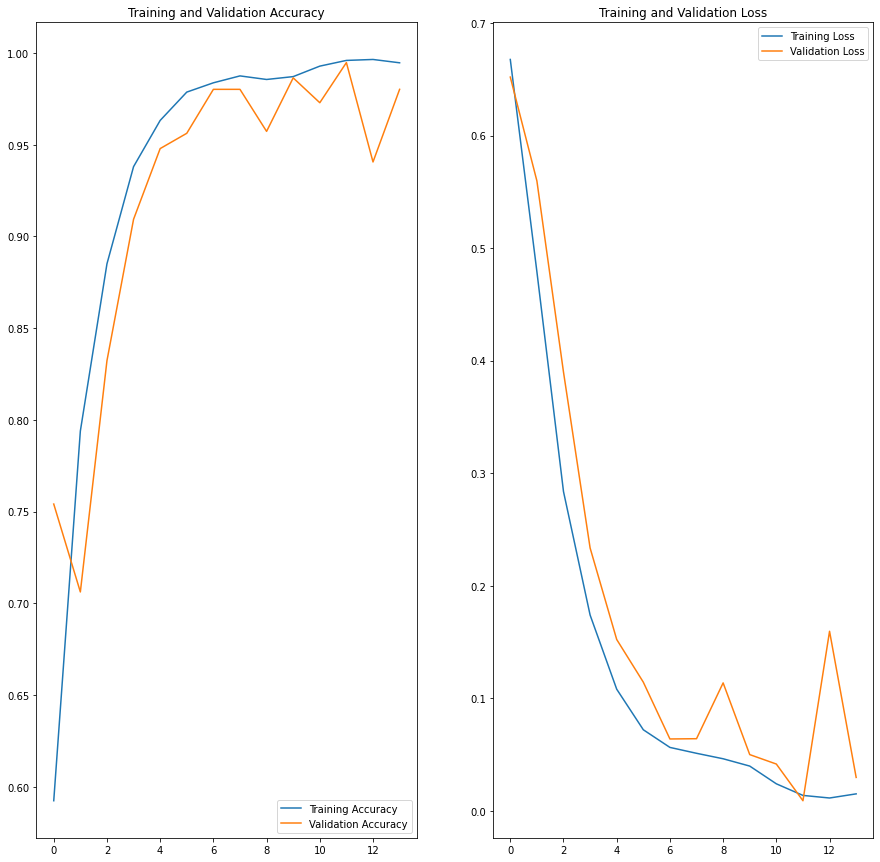

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

#epochs_range = range(22)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
results = model.evaluate(test_dataset)
print(results)

26/26 [==============================] - 0s 11ms/step - loss: 0.6919 - accuracy: 0.8065
[0.6919220685958862, 0.8064903616905212]


In [ ]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(df["cleanedCommentText"], df["Label"], test_size=.2)

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
  
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabert")

model = AutoModelForMaskedLM.from_pretrained("aubmindlab/bert-base-arabert")

Downloading:   0%|          | 0.00/637 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/578 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/717k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.26M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of the model checkpoint at aubmindlab/bert-base-arabert were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model.evaluate

<bound method ClassificationModel.evaluate of <simpletransformers.classification.classification_model.ClassificationModel object at 0x7f29cff3c050>>

In [ ]:
train_encodings = tokenizer(str(train_texts.values), truncation=True, padding=True)
val_encodings = tokenizer(str(val_texts.values), truncation=True, padding=True)
# test_encodings = tokenizer(str(test_texts.values), truncation=True, padding=True)

In [ ]:
val_encodings

<bound method BatchEncoding.sequence_ids of {'input_ids': [29756, 29759, 4, 857, 1005, 114, 114, 4, 4, 14465, 8221, 5467, 4124, 29759, 4738, 981, 6719, 7986, 990, 4, 4, 6903, 834, 25159, 1003, 980, 11975, 4, 11, 11, 11, 4, 112, 1002, 23631, 91, 28692, 8155, 900, 850, 28878, 1003, 91, 990, 445, 8154, 91, 28692, 117, 7822, 979, 20289, 23648, 978, 5034, 4490, 117, 7756, 28627, 980, 113, 8168, 8007, 117, 7816, 7869, 29759, 66, 1005, 1004, 1005, 4897, 51347, 117, 7865, 981, 1001, 117, 8154, 523, 978, 450, 8159, 745, 1004, 39865, 117, 28802, 7818, 857, 1004, 4, 4, 812, 8155, 6230, 8243, 445, 8141, 7914, 981, 20289, 4, 4, 22613, 1003, 445, 28118, 1007, 20347, 3697, 981, 17999, 1003, 5340, 445, 29347, 4, 29759, 29758], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
val_texts.values.shape

(2245,)

In [ ]:
train_encodings

{'input_ids': [29756, 29759, 4, 857, 1005, 114, 114, 4, 4, 14465, 8221, 5467, 4124, 29759, 4738, 981, 6719, 7986, 990, 4, 4, 6903, 834, 25159, 1003, 980, 11975, 4, 11, 11, 11, 4, 112, 1002, 23631, 91, 28692, 8155, 900, 850, 28878, 1003, 91, 990, 445, 8154, 91, 28692, 117, 7822, 979, 20289, 23648, 978, 5034, 4490, 117, 7756, 28627, 980, 113, 8168, 8007, 117, 7816, 7869, 29759, 66, 1005, 1004, 1005, 4897, 51347, 117, 7865, 981, 1001, 117, 8154, 523, 978, 450, 8159, 745, 1004, 39865, 117, 28802, 7818, 857, 1004, 4, 4, 812, 8155, 6230, 8243, 445, 8141, 7914, 981, 20289, 4, 4, 22613, 1003, 445, 28118, 1007, 20347, 3697, 981, 17999, 1003, 5340, 445, 29347, 4, 29759, 29758], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
from sklearn.model_selection import train_test_split
# Split Data
train_df, eval_df = train_test_split(df, test_size=0.1)

# Modelling

Using simpletransformers - see https://github.com/ThilinaRajapakse/simpletransformers for docs.

In [ ]:
train_df.columns = [ "labels","text"]
eval_df.columns = ["labels","text"]


In [ ]:
train_df

,labels,text
14315,1,هاد الحمارة لي تقول على المغرب ما يستاهل شكو...
4994,1,هههههه شي تكول بلبنان وشي بلكويت يااغبياء افته...
5474,0,هاي اول مره ادري ان الناس تتكلم عنه\nرغم أني م...
12303,1,وتامر آمين والنقاض كلهم معرصين متنسكو قضايا تخ...
4897,0,عاشت يدك كاظم مخبل الخليج الهمج شكد مقهورين منه
...,...,...
4595,0,احلام ملكه يعني ملكه غصب عن خشم الحاقدين
10160,0,اعجبتني فيها شخصيته القويه
6371,0,همزين كاظم مو مثل احلام جان عليمن يرد على واحد...
2591,1,ههههههههههههههههههه مسخره


In [ ]:
# # Setting up some logging (optional)
# logging.basicConfig(level=logging.INFO)
# transformers_logger = logging.getLogger("transformers")
# transformers_logger.setLevel(logging.WARNING)

# Specify some settings
args={'reprocess_input_data': True, 
      'overwrite_output_dir': True, 
      'num_labels': 2,
      'num_train_epochs': 2}

# Create a ClassificationModel
model = ClassificationModel('bert', "asafaya/bert-base-arabic", args=args, use_cuda=False)





Some weights of the model checkpoint at asafaya/bert-base-arabic were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at asafaya/bert-base-ar

In [ ]:
model.describe 

AttributeError: ignored

In [ ]:
# Train the model
model.train_model(train_df)

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df)

In [ ]:
result # Nice for interpretation

In [ ]:
# View the raw outputs
model_outputs

In [ ]:
# Convert to predicted class
pred_class = np.argmax(model_outputs, axis=-1)
pred_class

In [ ]:
# Score 
f1_score(eval_df['label'], pred_class)

In [ ]:
# And accuracy for interest: 
accuracy_score(eval_df['label'], pred_class)

# Generating Submission File

We get the model preds and save them following the sample submission.

In [ ]:
pred_labels, model_outputs = model.predict(test['text'])

In [ ]:
ss = pd.read_csv('SampleSubmission.csv')
ss.head()

In [ ]:
ss['label'] = pred_labels
ss.head()

In [ ]:
ss.to_csv('Sub1.csv', index=False)

# Good luck :)

by Johno Whitaker